Começamos fazendo as importações necessárias para o trabalho.

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

## Displacements


A função u(x, y) foi construída propositalmente para ser zero em toda a malha, mas com dependência explícita de x e y para que o PyTorch consiga computar derivadas.
A função v(x, y) é uma expressão quadrática simples em y, representando um deslocamento vertical. O termo **x² y² * 0** também é adicionado para manter a dependência de x, mesmo que o resultado seja 0.

In [3]:
u = lambda x, y: 0 * x ** 2 * y ** 2  # needed to force pytorch to evaluate gradient
v = lambda x, y: -1.7004e-7 * y ** 2 + x ** 2 * y ** 2 * 0

## Spatial grid creation

Criamos uma malha bidimensional de nx x ny pontos no domínio [-1, 1] × [-1, 1], com requires_grad=True para que possamos calcular gradientes posteriormente.

In [4]:
nx = 5
ny = 5

x = torch.linspace(-1, 1, nx, requires_grad=True)
y = torch.linspace(-1, 1, ny, requires_grad=True)
x, y = torch.meshgrid(x, y, indexing="ij")

## Sampled displacement field

Aqui concatenamos os deslocamentos:

- **d[0]:** deslocamento horizontal u(x, y) (zero)
- **d[1]:** deslocamento vertical v(x, y) (varia com y²)

In [5]:
d = torch.cat((u(x, y).unsqueeze(0), v(x, y).unsqueeze(0)), 0)
# the following is achieved by the concatenation
# d[0, :, :] == u(x,y)
# d[1, :, :] == v(x,y)

## Visualize displacement field

Um gráfico de setas (quiver) é utilizado para visualizar o campo vetorial de deslocamentos. Como u é nulo, as setas apontam apenas na direção vertical, com intensidade variando conforme y².

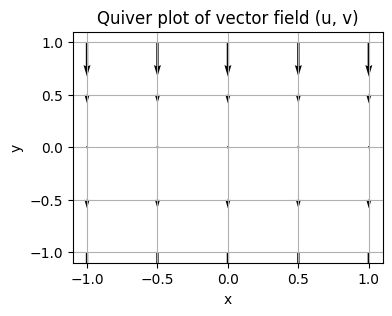

In [6]:
plt.figure(figsize=(4, 3))
plt.quiver(x.detach(), y.detach(), d[0, :, :].detach(), d[1, :, :].detach())
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quiver plot of vector field (u, v)')
plt.grid(True)
plt.show()

## Gradient computation

Neste trecho, utilizamos **torch.autograd.grad** para obter as derivadas parciais dos deslocamentos em relação a x e y.

Essas derivadas são armazenadas na matriz dd_dx, que tem shape **(2, 2, nx, ny)** e representa:

- **Dimensão 0:** componente de deslocamento (u ou v)
- **Dimensão 1:** direção da derivada (x ou y)

In [7]:
dd_dx = torch.zeros((2, 2, nx, ny))
dd_dx[0, 0] = grad(d[0], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]  # dd_dxdx
dd_dx[0, 1] = grad(d[0], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]  # dd_dxdy
dd_dx[1, 0] = grad(d[1], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]  # dd_dydx
dd_dx[1, 1] = grad(d[1], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]  # dd_dydy

print resultados do tensor

In [8]:
print(dd_dx[0, 0],
      dd_dx[0, 1],
      dd_dx[1, 0],
      dd_dx[1, 1])

tensor([[-0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<SelectBackward0>) tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<SelectBackward0>) tensor([[-0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<SelectBackward0>) tensor([[ 3.4008e-07,  1.7004e-07,  0.0000e+00, -1.7004e-07, -3.4008e-07],
        [ 3.4008e-07,  1.7004e-07,  0.0000e+00, -1.7004e-07, -3.4008e-07],
        [ 3.4008e-07,  1.7004e-07,  0.0000e+00, -1.7004e-07, -3.4008e-07],
        [ 3.4008e-07,  1.7004e-07,  0.0000e+00, -1.7004e-07, -3.4008e-07],
        [ 3.4008e-07,  1.7004e-07,  0.0000e+00, -1.7004e-07, -3.4008e-07]],
       grad_fn=<SelectBackward0>)


## Strain computation

Aqui aplicamos a fórmula de deformação linear:
O permute((1, 0, ...)) troca as componentes para somar corretamente os pares cruzados, como ∂u/∂y + ∂v/∂x.

In [9]:
eps = 0.5 * (dd_dx + dd_dx.permute((1, 0, 2, 3)))

## Material properties and 4th order material tensor

Criamos o tensor constitutivo elástico isotrópico com simetria plana. Este tensor C representa as propriedades do material (módulo de Young E e coeficiente de Poisson ν) para transformar deformações em tensões usando a Lei de Hooke.

In [10]:
E = 210000.0
nu = 0.3

C = torch.zeros((2, 2, 2, 2))  # 4th order material tensor
C[0, 0, 0, 0] = 1.0
C[0, 0, 1, 1] = nu
C[1, 1, 0, 0] = nu
C[1, 1, 1, 1] = 1.0
C[0, 1, 0, 1] = (1.0 - nu) / 2.0
C = E / (1.0 - nu ** 2) * C

## Stress computation

Calculamos o tensor de tensões σ multiplicando o tensor constitutivo pelo tensor de deformações:

In [11]:
sig = torch.tensordot(C, eps)

## Equilibrium computation

print resultados do tensor

In [12]:
grad(
    sig[0, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True, allow_unused=True
)

(tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]], grad_fn=<AddBackward0>),)

Usamos novamente autograd.grad para computar a divergência do tensor de tensões, que representa o resíduo de equilíbrio (força interna resultante em cada ponto da malha).

O vetor f representa o desbalanceamento interno:

- **f[0]:** direção x
- **f[1]:** direção y


In [13]:
dsig11_dx = grad(
    sig[0, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True, allow_unused=True
)[0]
dsig12_dy = grad(
    sig[0, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True, allow_unused=True
)[0]
dsig21_dx = grad(
    sig[1, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True, allow_unused=True
)[0]
dsig22_dy = grad(
    sig[1, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True, allow_unused=True
)[0]

f = torch.zeros((2, nx, ny))
f[0] = -dsig11_dx - dsig12_dy  # out of balance force in x1
f[1] = -dsig21_dx - dsig22_dy  # out of balance force in x2

## Density computation

print resultados do tensor

In [14]:
grad(sig[1, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True, allow_unused=True)

(tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]], grad_fn=<AddBackward0>),)

Aqui estimamos a densidade ρ do corpo assumindo que a força de desequilíbrio f[1] (em y) corresponde ao peso (ρg):
Essa densidade é então plotada para análise espacial.

In [15]:
g = 9810
rho = f[1] / g
print(rho)

tensor([[8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06]],
       grad_fn=<DivBackward0>)


## Result visualization: density
- **Note:** although there is only one color, the contourplot represent the density evaluated across multiple points

o cp = ax.contourf(x.detach(), y.detach(), rho.detach(), levels=12, cmap=plt.cm.jet):

Utilizamos um gráfico de contorno para visualizar a distribuição espacial da densidade ρ estimada. Isso ajuda a entender como a tensão interna varia na estrutura devido à deformação imposta.

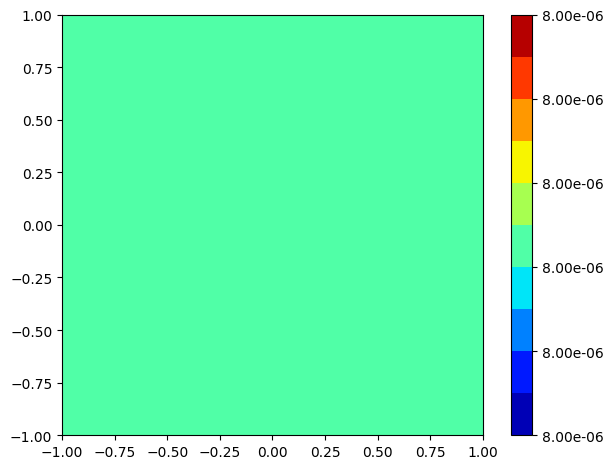

In [ ]:
fig, ax = plt.subplots()
cp = ax.contourf(x.detach(), y.detach(), rho.detach(), levels=12, cmap=plt.cm.jet)
fig.colorbar(cp, format="%.2e")
ax.set_aspect("equal")
fig.tight_layout()
plt.show()